<center><h1>Minimum Distance Classifier (MDC)</h1></center>

# Summary:

<h3>

1. [Introduction](#introduction)


2. [Simulations](#simulations)
    
    2.1. [Model fitting](#model_fitting)
    
    2.2 [Accuracy distribution](#accuracy_distribution)
    
    2.3 [Projection of discriminative functions in bi-dimensional space](#projections)
    
</h3>

# 1. Introduction <a class="anchor" id="introduction"></a>

This classifier assumes that each data point of class $L_i$, of our set $\Omega = \{ L_i \}_{i=1}^{N_c}$, was drawn from a gaussian distribution, which has the probability density function of the form

\begin{equation}
    f_i(\vec{x} \ | \ \vec{\mu}_i, \Sigma_i) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_i|}} \exp \Big[{-\frac{1}{2}(\vec{x}-\vec{\mu}_i)^T\Sigma_i^{-1}(\vec{x}-\vec{\mu}_i)} \Big],
\end{equation}
where $\vec{x} \in \mathbb{R}^d$ is the input vector and $\vec{\mu}_i$ and $\Sigma_i$ are, respectivaly, the mean and covariance matrix of class $L_i$.

Our final supposition is that every class has the same covariance matrix, so $\forall i,j, \ \Sigma_i = \Sigma_j=I_d$. The problem of finding the most probable class of a sample $\vec{x}$ is reduced to
\begin{equation}
    g(\vec{x}) = {\displaystyle \arg \min_{1 \leq i \leq N_c} \| \vec{x} - \vec{\mu}_i \|_2^2},
\end{equation}
where a result $j$ in the discriminative function $g(\vec{x})$ means that $\vec{x}$ has a higher probability of belonging to class $L_j$.

The code below implements a class to represent this classifier.

In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist

class MDC():
    def __init__(self):
        self.class_list = {}
        self.centroids = {}
    
    def fit(self, X, y):
        self.class_list = np.unique(y, axis=0)
        
        self.centroids = np.zeros((len(self.class_list), X.shape[1])) # each row is a centroid
        for i in range(len(self.class_list)): # for each class, we evaluate its centroid
            temp = np.where(y==self.class_list[i])[0]
            self.centroids[i,:] = np.mean(X[temp],axis=0)
            
            
    def predict(self, X):
        temp = np.argmin(
            cdist(X, self.centroids), # distance between each pair of the two collections of inputs
            axis=1
        )
        y_pred = np.array([self.class_list[i] for i in temp])

        return y_pred

# 2. Simulations <a class="anchor" id="simulations"></a>

## 2.1 Model fitting <a class="anchor" id="model_fitting"></a>

We took some data sets available on the `sklearn` library:

In [2]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

datasets = {
    'Iris'          : load_iris(),
    'Digits'        : load_digits(),
    'Wine'          : load_wine(),
    'Breast cancer' : load_breast_cancer()
}

for dataset_name in datasets:
    print("{}\n# of samples:  {}\n# of features: {}\n# of classes:  {}\n".format(
        dataset_name,
        len(datasets[dataset_name].data),
        datasets[dataset_name].data.shape[1],
        len(np.unique(datasets[dataset_name].target))
    ))

Iris
# of samples:  150
# of features: 4
# of classes:  3

Digits
# of samples:  1797
# of features: 64
# of classes:  10

Wine
# of samples:  178
# of features: 13
# of classes:  3

Breast cancer
# of samples:  569
# of features: 30
# of classes:  2



Simulation methodology:

* Train/test split of 80%/20%;
* Feature scaling: [0, 1];
* 100 independent train/test splits;
* Performance metric: accuracy.

In [3]:
# hyperparameters
n_resamplings = 100
test_size = 0.2

In [4]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

results = {
    dataset_name: {
        'train' : [None]*n_resamplings, 
        'test'  : [None]*n_resamplings
    }
    for dataset_name in datasets
}


for dataset_name in datasets:
    X = datasets[dataset_name].data
    Y = datasets[dataset_name].target
    
    for i in range(n_resamplings):
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

        # scaling
        scaler = MinMaxScaler()
        X_tr_scaled = scaler.fit_transform(X_train) # learn transform from train data only
        X_ts_scaled = scaler.transform(X_test)

        # model fitting
        mdc = MDC()
        mdc.fit(X_tr_scaled, y_train)

        # model evaluation
        y_pred_tr = mdc.predict(X_tr_scaled)
        y_pred_ts = mdc.predict(X_ts_scaled)
        results[dataset_name]['train'][i] = accuracy_score(y_train, y_pred_tr)*100 # %
        results[dataset_name]['test'][i]  = accuracy_score(y_test,  y_pred_ts)*100 # %

        
    print(dataset_name+" done")

Iris done
Digits done
Wine done
Breast cancer done
CPU times: user 760 ms, sys: 0 ns, total: 760 ms
Wall time: 778 ms


## 2.2 Accuracy distribution <a class="anchor" id="accuracy_distribution"></a>

In [5]:
from IPython.core.display import display, HTML
import plotly.graph_objs as go

for dataset_name in datasets:
    display(HTML('<center><h1>'+dataset_name+'</h1></center>'))
    
    boxs = []
    for set_ in ['train', 'test']:
        boxs.append(
            go.Box(
                y = results[dataset_name][set_],
                x = ["{}{} set".format(set_[0].upper(), set_[1:])
                    ]*len(results[dataset_name][set_]),
                boxmean='sd'
                )
        )
        
    fig = go.Figure(data   = boxs,
                    layout = go.Layout(showlegend=False)
                   )
    
    # connecting means of train and test sets
    fig.add_trace(go.Scatter(
        x=['Train set', 'Test set'],
        y=[np.mean(results[dataset_name]['train']),
           np.mean(results[dataset_name]['test'])],
        mode='lines+markers',
        line=dict(
            color="#3498db",
            dash="dashdot",
            width=2
        ),
        showlegend=False
    ))
    
    
    fig.update_layout(
        margin=dict(l=70, r=70, t=5, b=10),
        font=dict(size=15),
        yaxis=dict(title='Accuracy (%)'),
    )
    
    fig.show()
    
    display(HTML('<hr>'))

## 2.3 Projection of discriminative functions in bi-dimensional space <a class="anchor" id="projections"></a>

In this section, we project the whole data set and the decision function of the MDC on a 2D space using *Principal Component Analysis* (PCA).

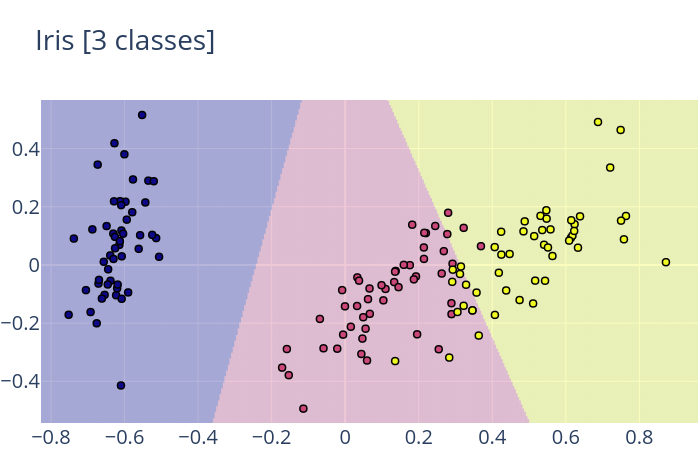

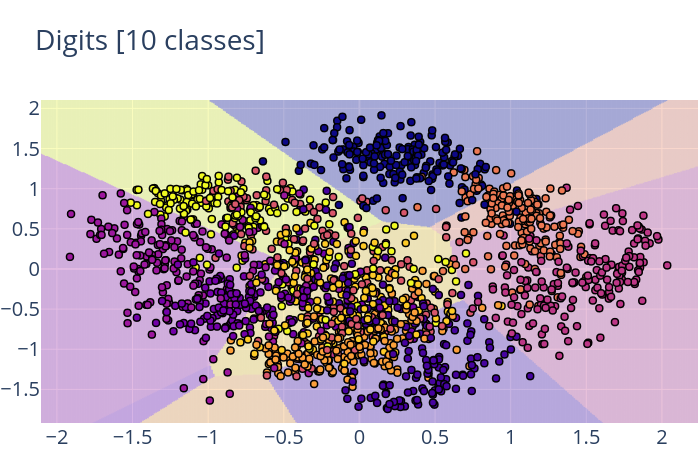

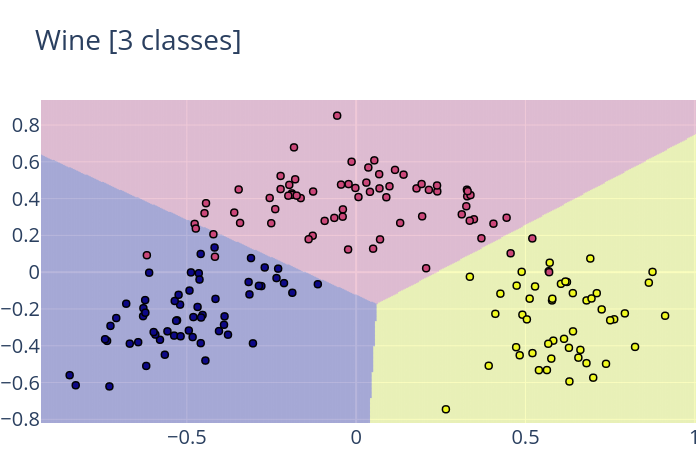

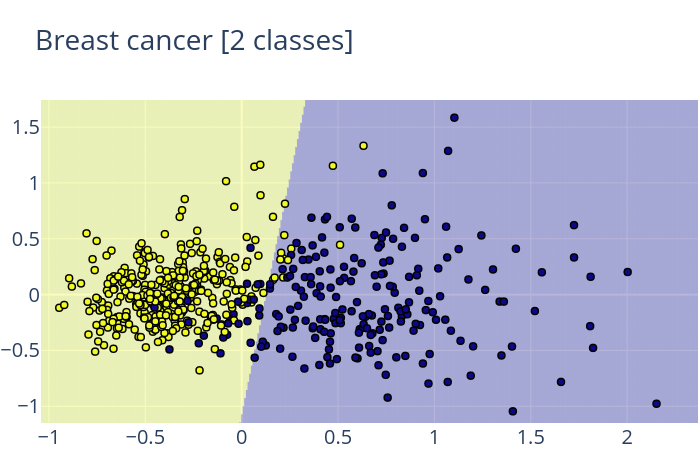

In [6]:
from IPython.core.display import display, HTML
import plotly.graph_objs as go
from sklearn.decomposition import PCA

for dataset_name in datasets:
    X = datasets[dataset_name].data
    Y = datasets[dataset_name].target
    
    # fitting the MDC again
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    scaler = MinMaxScaler()
    X_tr_scaled = scaler.fit_transform(X_train) # learn transform from train data only
    X_ts_scaled = scaler.transform(X_test)
    
    mdc = MDC()
    mdc.fit(X_tr_scaled, y_train)

    
    # projecting in 2D space
    X_full = np.vstack((X_tr_scaled, X_ts_scaled)) # required due to the new sample order
    pca  = PCA(n_components=2)
    X_2d = pca.fit_transform(X_full)
    
    
    # Making graph
    fig = go.Figure()
   
    n = 400 # number of points in each dimension
    size = 2 # size of points in the coloring grid
    
    x_max, y_max = X_2d.max(0)
    x_min, y_min = X_2d.min(0)
    x = np.linspace(x_min*1.1, x_max*1.1, n)
    y = np.linspace(y_min*1.1, y_max*1.1, n)
    # creating the coloring grid data points
    xv, yv = np.meshgrid(x, y)
    x = xv.flatten()
    y = yv.flatten()
    
    grid_pred = mdc.predict(
        # predictions need to take place in original high dimensional space
        pca.inverse_transform( np.column_stack((x, y)) )
    )
    
    # coloring grid (coloring the regions)
    fig.add_trace(go.Scatter(
        x = x.tolist(),
        y = y.tolist(),
        mode='markers',
        opacity=0.3,
        marker = dict( size=size, color= grid_pred )
    ))
    
    # data set projection in 2d space
    fig.add_trace(go.Scatter(
        x=X_2d[:,0],
        y=X_2d[:,1],
        mode='markers',
        marker = dict(
            size  = 7,
            color = np.concatenate([y_train,y_test]),
            line  = dict(width=1.5,color='#000000')
        )
    ))

    fig.update_layout(
        margin=dict(l=20, r=2, b=0),#t=20),
        font=dict(size=20),
        autosize=False,
        width  = 600,
        height = 600,
        showlegend = False,
        title='{} [{} classes]'.format(dataset_name, len(np.unique(Y)))
    )

    fig.update_xaxes(range=[x_min*1.1, x_max*1.1]) 
    fig.update_yaxes(range=[y_min*1.1, y_max*1.1])
    
    fig.show(renderer="png")
    display(HTML('<hr>'))